<a href="https://colab.research.google.com/github/WeslleyRSantos/HadoopAula/blob/main/Hadoop_Aula_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
#PySpark
!apt-get -qq update
!apt-get -qq install -y openjdk-17-jdk-headless
!pip -q install -U pyspark[connect]==4.0.0

print('✅ PySpark instalado com sucesso!')


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
✅ PySpark instalado com sucesso!


In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

#  SparkSession
spark = SparkSession.builder \
    .master('local[*]') \
    .appName('ExerciciosML') \
    .getOrCreate()

print('✅ SparkSession criada com sucesso!')


✅ SparkSession criada com sucesso!


In [11]:

!pip install -q kagglehub

import kagglehub

# dataset
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")

print("✅ Dataset baixado em:", path)


Using Colab cache for faster access to the 'brazilian-ecommerce' dataset.
✅ Dataset baixado em: /kaggle/input/brazilian-ecommerce


In [12]:
import os, glob

files = sorted(glob.glob(path + "/*.csv"))
print(f"Total de arquivos: {len(files)}\n")
for f in files:
    print(f"  - {os.path.basename(f)}")


Total de arquivos: 9

  - olist_customers_dataset.csv
  - olist_geolocation_dataset.csv
  - olist_order_items_dataset.csv
  - olist_order_payments_dataset.csv
  - olist_order_reviews_dataset.csv
  - olist_orders_dataset.csv
  - olist_products_dataset.csv
  - olist_sellers_dataset.csv
  - product_category_name_translation.csv


In [13]:
from pyspark.sql import functions as F


orders = spark.read.csv(path + "/olist_orders_dataset.csv", header=True, inferSchema=True)
customers = spark.read.csv(path + "/olist_customers_dataset.csv", header=True, inferSchema=True)
items = spark.read.csv(path + "/olist_order_items_dataset.csv", header=True, inferSchema=True)
products = spark.read.csv(path + "/olist_products_dataset.csv", header=True, inferSchema=True)
sellers = spark.read.csv(path + "/olist_sellers_dataset.csv", header=True, inferSchema=True)
geolocation = spark.read.csv(path + "/olist_geolocation_dataset.csv", header=True, inferSchema=True)
payments = spark.read.csv(path + "/olist_order_payments_dataset.csv", header=True, inferSchema=True)

print("✅ Datasets carregados:")
print(f"  - Orders: {orders.count()}")
print(f"  - Customers: {customers.count()}")
print(f"  - Items: {items.count()}")
print(f"  - Products: {products.count()}")
print(f"  - Sellers: {sellers.count()}")
print(f"  - Payments: {payments.count()}")


✅ Datasets carregados:
  - Orders: 99441
  - Customers: 99441
  - Items: 112650
  - Products: 32951
  - Sellers: 3095
  - Payments: 103886


In [14]:

orders2 = (
    orders
    .withColumn("purchase_ts", F.to_timestamp("order_purchase_timestamp"))
    .withColumn("delivered_ts", F.to_timestamp("order_delivered_customer_date"))
    .withColumn("estimated_ts", F.to_timestamp("order_estimated_delivery_date"))
)

orders2 = orders2.filter(
    F.col("delivered_ts").isNotNull() &
    F.col("estimated_ts").isNotNull() &
    F.col("purchase_ts").isNotNull()
)

orders2 = orders2.withColumn("late", (F.col("delivered_ts") > F.col("estimated_ts")).cast("int"))

print("✅ Base de pedidos preparada")
orders2.select("order_id", "late", "purchase_ts", "delivered_ts", "estimated_ts").show(5)


✅ Base de pedidos preparada
+--------------------+----+-------------------+-------------------+-------------------+
|            order_id|late|        purchase_ts|       delivered_ts|       estimated_ts|
+--------------------+----+-------------------+-------------------+-------------------+
|e481f51cbdc54678b...|   0|2017-10-02 10:56:33|2017-10-10 21:25:13|2017-10-18 00:00:00|
|53cdb2fc8bc7dce0b...|   0|2018-07-24 20:41:37|2018-08-07 15:27:45|2018-08-13 00:00:00|
|47770eb9100c2d0c4...|   0|2018-08-08 08:38:49|2018-08-17 18:06:29|2018-09-04 00:00:00|
|949d5b44dbf5de918...|   0|2017-11-18 19:28:06|2017-12-02 00:28:42|2017-12-15 00:00:00|
|ad21c59c0840e6cb8...|   0|2018-02-13 21:18:39|2018-02-16 18:17:02|2018-02-26 00:00:00|
+--------------------+----+-------------------+-------------------+-------------------+
only showing top 5 rows


In [15]:

items_with_product = items.join(products, on="product_id", how="left")


items_agg = (
    items_with_product.groupBy("order_id")
    .agg(
        F.count("*").alias("n_items"),
        F.sum("price").alias("total_price"),
        F.sum("freight_value").alias("total_freight"),
        F.first("product_category_name").alias("main_category"),  # categoria principal
        F.first("seller_id").alias("main_seller")  # vendedor principal
    )
)

print("✅ Itens agregados com categoria e vendedor")
items_agg.show(5, truncate=False)


✅ Itens agregados com categoria e vendedor
+--------------------------------+-------+-----------+-------------+------------------+--------------------------------+
|order_id                        |n_items|total_price|total_freight|main_category     |main_seller                     |
+--------------------------------+-------+-----------+-------------+------------------+--------------------------------+
|00018f77f2f0320c557190d7a144bdd3|1      |239.9      |19.93        |pet_shop          |dd7ddc04e1b6c2c614352b383efe2d36|
|000229ec398224ef6ca0657da4fc703e|1      |199.0      |17.87        |moveis_decoracao  |5b51032eddd242adc84c38acab88f23d|
|00024acbcdf0a6daa1e931b038114c75|1      |12.99      |12.79        |perfumaria        |9d7a1d34a5052409006425275ba1c2b4|
|00042b26cf59d7ce69dfabb4e55b4fd9|1      |199.9      |18.14        |ferramentas_jardim|df560393f3a51e74553ab94004ba5c87|
|00054e8431b9d7675808bcb819fb4a32|1      |19.9       |11.85        |telefonia         |7040e82f899a04d1b434b79

In [16]:

customers_geo = (
    customers
    .join(
        geolocation.groupBy("geolocation_zip_code_prefix")
        .agg(
            F.avg("geolocation_lat").alias("customer_lat"),
            F.avg("geolocation_lng").alias("customer_lng")
        ),
        customers.customer_zip_code_prefix == F.col("geolocation_zip_code_prefix"),
        how="left"
    )
    .select("customer_id", "customer_state", "customer_lat", "customer_lng")
)


sellers_geo = (
    sellers
    .join(
        geolocation.groupBy("geolocation_zip_code_prefix")
        .agg(
            F.avg("geolocation_lat").alias("seller_lat"),
            F.avg("geolocation_lng").alias("seller_lng")
        ),
        sellers.seller_zip_code_prefix == F.col("geolocation_zip_code_prefix"),
        how="left"
    )
    .select("seller_id", "seller_state", "seller_lat", "seller_lng")
)

print("✅ Coordenadas geográficas preparadas")


✅ Coordenadas geográficas preparadas


In [17]:

customers_geo = (
    customers
    .join(
        geolocation.groupBy("geolocation_zip_code_prefix")
        .agg(
            F.avg("geolocation_lat").alias("customer_lat"),
            F.avg("geolocation_lng").alias("customer_lng")
        ),
        customers.customer_zip_code_prefix == F.col("geolocation_zip_code_prefix"),
        how="left"
    )
    .select("customer_id", "customer_state", "customer_lat", "customer_lng")
)


sellers_geo = (
    sellers
    .join(
        geolocation.groupBy("geolocation_zip_code_prefix")
        .agg(
            F.avg("geolocation_lat").alias("seller_lat"),
            F.avg("geolocation_lng").alias("seller_lng")
        ),
        sellers.seller_zip_code_prefix == F.col("geolocation_zip_code_prefix"),
        how="left"
    )
    .select("seller_id", "seller_state", "seller_lat", "seller_lng")
)

print("✅ Coordenadas geográficas preparadas")


✅ Coordenadas geográficas preparadas


In [18]:

orders_volume = (
    orders2
    .withColumn("purchase_date", F.to_date("purchase_ts"))
    .groupBy("purchase_date")
    .agg(F.count("*").alias("daily_orders"))
)


orders3 = orders2.join(
    orders_volume.withColumnRenamed("purchase_date", "pd"),
    F.to_date(orders2.purchase_ts) == F.col("pd"),
    how="left"
).drop("pd")

print("✅ Volume de pedidos calculado")


✅ Volume de pedidos calculado


In [19]:

base = (
    orders3.select("order_id", "customer_id", "order_status", "purchase_ts", "delivered_ts", "estimated_ts", "late", "daily_orders")
    .join(customers_geo, on="customer_id", how="left")
    .join(items_agg, on="order_id", how="left")
    .join(sellers_geo.withColumnRenamed("seller_id", "main_seller"), on="main_seller", how="left")
    .fillna({
        "n_items": 0,
        "total_price": 0.0,
        "total_freight": 0.0,
        "daily_orders": 0
    })
)


base = base.withColumn(
    "distance_km",
    F.sqrt(
        F.pow((F.col("customer_lat") - F.col("seller_lat")) * 111, 2) +
        F.pow((F.col("customer_lng") - F.col("seller_lng")) * 111, 2)
    )
)


base = (
    base
    .withColumn("dow", F.dayofweek("purchase_ts"))
    .withColumn("hour", F.hour("purchase_ts"))
    .withColumn("days_estimated", (F.col("estimated_ts").cast("long") - F.col("purchase_ts").cast("long")) / 86400.0)
)

print("✅ Base final montada")
base.select("late", "customer_state", "main_category", "n_items", "distance_km", "daily_orders").show(5, truncate=False)


✅ Base final montada
+----+--------------+---------------------+-------+------------------+------------+
|late|customer_state|main_category        |n_items|distance_km       |daily_orders|
+----+--------------+---------------------+-------+------------------+------------+
|0   |BA            |perfumaria           |1      |850.26266541816   |264         |
|0   |RN            |pet_shop             |1      |1832.8605092262158|141         |
|0   |SP            |papelaria            |1      |31.680665626203254|217         |
|0   |SP            |utilidades_domesticas|1      |19.60345566546049 |140         |
|0   |GO            |automotivo           |1      |513.613514728599  |310         |
+----+--------------+---------------------+-------+------------------+------------+
only showing top 5 rows


In [20]:
data = base.select(
    "late",
    "order_status",
    "customer_state",
    "main_category",
    "n_items",
    "total_price",
    "total_freight",
    "dow",
    "hour",
    "days_estimated",
    "distance_km",
    "daily_orders"
).na.drop()

train, test = data.randomSplit([0.8, 0.2], seed=42)

print(f"✅ Train: {train.count()} | Test: {test.count()}")


✅ Train: 75819 | Test: 18826


In [21]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator


idx_status = StringIndexer(inputCol="order_status", outputCol="status_idx", handleInvalid="keep")
idx_state = StringIndexer(inputCol="customer_state", outputCol="state_idx", handleInvalid="keep")
idx_category = StringIndexer(inputCol="main_category", outputCol="category_idx", handleInvalid="keep")


ohe = OneHotEncoder(
    inputCols=["status_idx", "state_idx", "category_idx"],
    outputCols=["status_ohe", "state_ohe", "category_ohe"]
)


vec = VectorAssembler(
    inputCols=[
        "status_ohe", "state_ohe", "category_ohe",
        "n_items", "total_price", "total_freight",
        "dow", "hour", "days_estimated",
        "distance_km", "daily_orders"
    ],
    outputCol="features"
)


lr = LogisticRegression(featuresCol="features", labelCol="late", maxIter=30)


pipe = Pipeline(stages=[idx_status, idx_state, idx_category, ohe, vec, lr])

print("✅ Pipeline criado")


✅ Pipeline criado


In [22]:

model = pipe.fit(train)


pred = model.transform(test)


evaluator = BinaryClassificationEvaluator(
    labelCol="late",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

auc = evaluator.evaluate(pred)
print(f"🎯 AUC (com novas features): {auc:.4f}")

pred.select("late", "probability", "prediction").show(10, truncate=False)


🎯 AUC (com novas features): 0.7148
+----+-----------------------------------------+----------+
|late|probability                              |prediction|
+----+-----------------------------------------+----------+
|0   |[0.9201390787222141,0.07986092127778588] |0.0       |
|0   |[0.9689611436067125,0.031038856393287517]|0.0       |
|0   |[0.9537941657035416,0.046205834296458415]|0.0       |
|0   |[0.8999390143996502,0.10006098560034982] |0.0       |
|0   |[0.9720276525707707,0.027972347429229272]|0.0       |
|0   |[0.9480466359308357,0.05195336406916429] |0.0       |
|0   |[0.9196865103933605,0.08031348960663953] |0.0       |
|0   |[0.975020747646754,0.02497925235324605]  |0.0       |
|0   |[0.396654583585891,0.603345416414109]    |1.0       |
|0   |[0.6795615880103705,0.3204384119896295]  |0.0       |
+----+-----------------------------------------+----------+
only showing top 10 rows


In [23]:

payments_main = (
    payments.groupBy("order_id")
    .agg(F.first("payment_type").alias("payment_type"))
)


base_payment = (
    orders.select("order_id", "customer_id", "order_status", "order_purchase_timestamp")
    .join(customers.select("customer_id", "customer_state"), on="customer_id", how="left")
    .join(items_agg.select("order_id", "n_items", "total_price", "total_freight", "main_category"), on="order_id", how="left")
    .join(payments_main, on="order_id", how="left")
    .fillna({"n_items": 0, "total_price": 0.0, "total_freight": 0.0})
)


base_payment = (
    base_payment
    .withColumn("purchase_ts", F.to_timestamp("order_purchase_timestamp"))
    .withColumn("dow", F.dayofweek("purchase_ts"))
    .withColumn("hour", F.hour("purchase_ts"))
)

print("✅ Base para payment_type preparada")
base_payment.select("order_id", "payment_type", "customer_state", "total_price", "n_items").show(5)


✅ Base para payment_type preparada
+--------------------+------------+--------------+-----------+-------+
|            order_id|payment_type|customer_state|total_price|n_items|
+--------------------+------------+--------------+-----------+-------+
|53cdb2fc8bc7dce0b...|      boleto|            BA|      118.7|      1|
|ad21c59c0840e6cb8...| credit_card|            SP|       19.9|      1|
|949d5b44dbf5de918...| credit_card|            RN|       45.0|      1|
|e481f51cbdc54678b...| credit_card|            SP|      29.99|      1|
|a4591c265e18cb1dc...| credit_card|            PR|      147.9|      1|
+--------------------+------------+--------------+-----------+-------+
only showing top 5 rows


In [24]:
data_payment = base_payment.select(
    "payment_type",
    "order_status",
    "customer_state",
    "main_category",
    "n_items",
    "total_price",
    "total_freight",
    "dow",
    "hour"
).na.drop()

train_pay, test_pay = data_payment.randomSplit([0.8, 0.2], seed=42)

print(f"✅ Train: {train_pay.count()} | Test: {test_pay.count()}")


✅ Train: 77769 | Test: 19480


In [25]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


idx_payment = StringIndexer(inputCol="payment_type", outputCol="label", handleInvalid="keep")


idx_status_pay = StringIndexer(inputCol="order_status", outputCol="status_idx", handleInvalid="keep")
idx_state_pay = StringIndexer(inputCol="customer_state", outputCol="state_idx", handleInvalid="keep")
idx_category_pay = StringIndexer(inputCol="main_category", outputCol="category_idx", handleInvalid="keep")


ohe_pay = OneHotEncoder(
    inputCols=["status_idx", "state_idx", "category_idx"],
    outputCols=["status_ohe", "state_ohe", "category_ohe"]
)


vec_pay = VectorAssembler(
    inputCols=[
        "status_ohe", "state_ohe", "category_ohe",
        "n_items", "total_price", "total_freight",
        "dow", "hour"
    ],
    outputCol="features"
)


dt = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=10)


pipe_pay = Pipeline(stages=[idx_payment, idx_status_pay, idx_state_pay, idx_category_pay, ohe_pay, vec_pay, dt])

print("✅ Pipeline de Árvore de Decisão criado")


✅ Pipeline de Árvore de Decisão criado


In [26]:

model_pay = pipe_pay.fit(train_pay)


pred_pay = model_pay.transform(test_pay)


evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = evaluator_acc.evaluate(pred_pay)
print(f"🎯 Acurácia (Árvore de Decisão): {accuracy:.4f}")

pred_pay.select("payment_type", "prediction", "probability").show(10, truncate=False)


🎯 Acurácia (Árvore de Decisão): 0.7584
+------------+----------+--------------------------------------------------------------------------------------+
|payment_type|prediction|probability                                                                           |
+------------+----------+--------------------------------------------------------------------------------------+
|boleto      |0.0       |[0.8031000950500841,0.1673612634349638,0.017474592381370183,0.012064049133581925,0.0] |
|boleto      |0.0       |[0.7004678489827004,0.24937438798824937,0.03187901207703188,0.01827875095201828,0.0]  |
|boleto      |0.0       |[0.665158371040724,0.3031674208144796,0.027149321266968326,0.004524886877828055,0.0]  |
|boleto      |0.0       |[0.8516483516483516,0.1282051282051282,0.01282051282051282,0.007326007326007326,0.0]  |
|boleto      |0.0       |[0.7923254029163469,0.16699923254029164,0.028702993092862623,0.011972371450498849,0.0]|
|boleto      |0.0       |[0.7520391517128875,0.2075856443

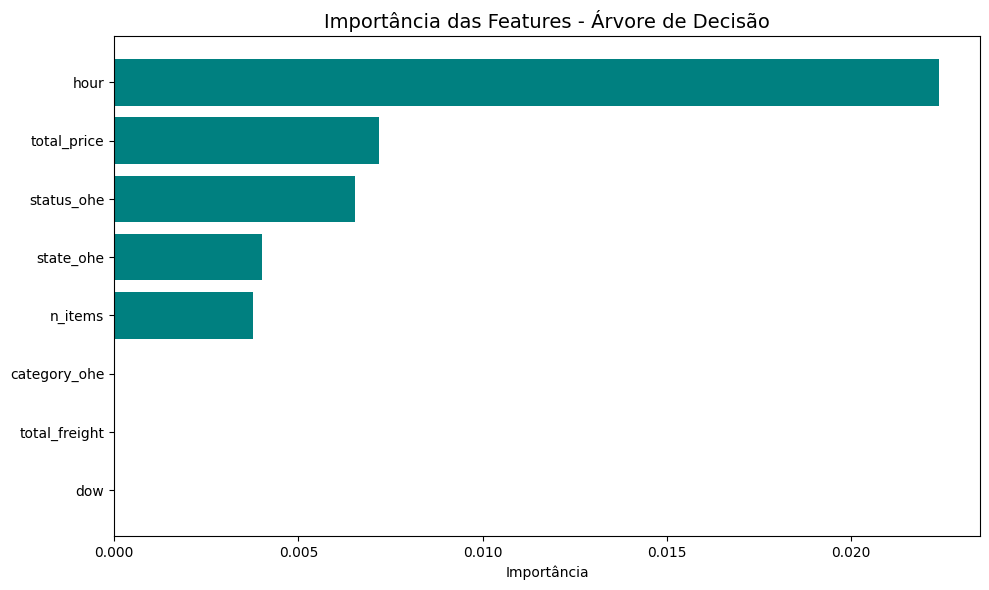

         feature  importance
7           hour    0.022373
4    total_price    0.007197
0     status_ohe    0.006545
1      state_ohe    0.004008
3        n_items    0.003778
2   category_ohe    0.000000
5  total_freight    0.000000
6            dow    0.000000


In [27]:
import pandas as pd
import matplotlib.pyplot as plt


dt_model = model_pay.stages[-1]


feature_names = vec_pay.getInputCols()


importances = dt_model.featureImportances.toArray()


df_importance = pd.DataFrame({
    "feature": feature_names,
    "importance": importances[:len(feature_names)]
}).sort_values("importance", ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(df_importance["feature"][::-1], df_importance["importance"][::-1], color='teal')
plt.title("Importância das Features - Árvore de Decisão", fontsize=14)
plt.xlabel("Importância")
plt.tight_layout()
plt.show()

print(df_importance)
